Mengimport Library, termasuk model VGG16

In [54]:
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import cv2

Membuat Dataset MNIST

In [55]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Tambahkan dimensi channel dan ubah grayscale menjadi RGB

In [56]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [57]:
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

Resize ke ukuran input VGG16


In [58]:
x_train = tf.image.resize(x_train, [32, 32])
x_test = tf.image.resize(x_test, [32, 32])

Normalisasi data train test dan encode menjadi kategorikal

In [59]:
# Normalisasi data train test
x_train = x_train / 255.0
x_test = x_test / 255.0

# encoding untuk 10 kelas
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [60]:
print("Shape data latih:", x_train.shape)
print("Shape data uji:", x_test.shape)

Shape data latih: (60000, 32, 32, 3)
Shape data uji: (10000, 32, 32, 3)


menggunakan arsitektur VGG16 dengan bobot awal dari ImageNet sebagai dasar transfer learning

In [61]:
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(32,32,3))

Freeze layer

In [62]:
for layer in base_model.layers:
    layer.trainable = False

Membangun arsitektur pada model dan ringkasan model

In [63]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # output 10 kelas (0-9)
])

In [64]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Proses kompile model

In [65]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

memperbanyak variasi data latih dengan transformasi acak seperti rotasi, zoom, dan pergeseran posisi gambar

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
datagen.fit(x_train)

Proses Pelatihan Model

In [67]:
history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=64),
                      validation_data=(x_test, y_test_cat),
                      epochs=5)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 896s 952ms/step - accuracy: 0.6416 - loss: 1.1045 - val_accuracy: 0.9151 - val_loss: 0.2939
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 875s 933ms/step - accuracy: 0.8801 - loss: 0.3861 - val_accuracy: 0.9404 - val_loss: 0.1987
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 874s 932ms/step - accuracy: 0.9093 - loss: 0.2916 - val_accuracy: 0.9462 - val_loss: 0.1757
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 874s 932ms/step - accuracy: 0.9225 - loss: 0.2518 - val_accuracy: 0.9494 - val_loss: 0.1599
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 898s 958ms/step - accuracy: 0.9297 - loss: 0.2252 - val_accuracy: 0.9536 - val_loss: 0.1442


Menampilkan Akurasi Model

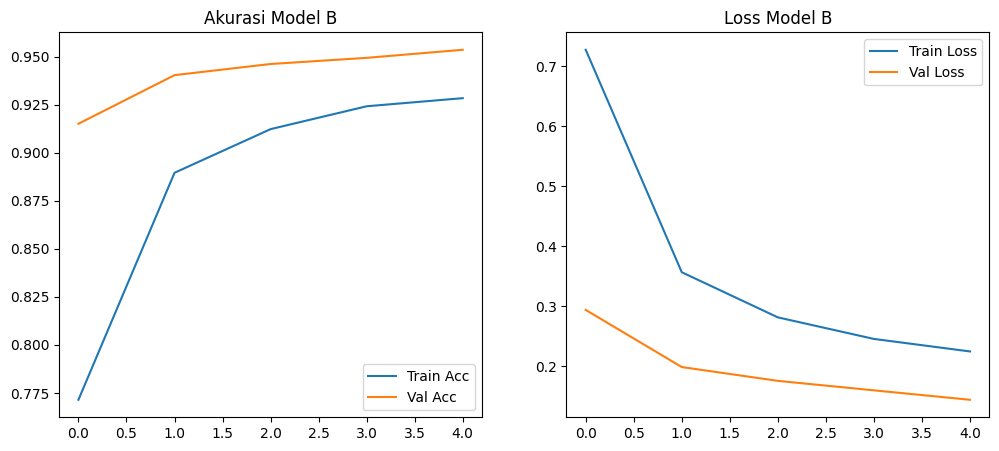

In [68]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi Model B')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Model B')
plt.legend()
plt.show()

## Lakukan prediksi menggunakan citra tulisan tangan

upload file citra

In [69]:
from google.colab import files

uploaded = files.upload()
file_names = list(uploaded.keys())
print("File terunggah:", file_names)

Saving 1_1.jpg to 1_1 (1).jpg
Saving 1_2.jpg to 1_2 (1).jpg
Saving 1_3.jpg to 1_3 (1).jpg
Saving 1_4.jpg to 1_4 (1).jpg
Saving 1_5.jpg to 1_5 (1).jpg
Saving 1_6.jpg to 1_6 (1).jpg
Saving 1_7.jpg to 1_7 (1).jpg
Saving 1_8.jpg to 1_8 (1).jpg
Saving 1_9.jpg to 1_9 (1).jpg
Saving 1_10.jpg to 1_10 (1).jpg
Saving 2_1.jpg to 2_1 (1).jpg
Saving 2_2.jpg to 2_2 (1).jpg
Saving 2_3.jpg to 2_3 (1).jpg
Saving 2_4.jpg to 2_4 (1).jpg
Saving 2_5.jpg to 2_5 (1).jpg
Saving 2_6.jpg to 2_6 (1).jpg
Saving 2_7.jpg to 2_7 (1).jpg
Saving 2_8.jpg to 2_8 (1).jpg
Saving 2_9.jpg to 2_9 (1).jpg
Saving 2_10.jpg to 2_10 (1).jpg
Saving 8_1.jpg to 8_1 (1).jpg
Saving 8_2.jpg to 8_2 (1).jpg
Saving 8_3.jpg to 8_3 (1).jpg
Saving 8_4.jpg to 8_4 (1).jpg
Saving 8_5.jpg to 8_5 (1).jpg
Saving 8_6.jpg to 8_6 (1).jpg
Saving 8_7.jpg to 8_7 (1).jpg
Saving 8_8.jpg to 8_8 (1).jpg
Saving 8_9.jpg to 8_9 (1).jpg
Saving 8_10.jpg to 8_10 (1).jpg
File terunggah: ['1_1 (1).jpg', '1_2 (1).jpg', '1_3 (1).jpg', '1_4 (1).jpg', '1_5 (1).jpg', '1

Variabel Penampung untuk data citra

In [70]:
data_citra = []      # gambar hasil preprocessing
label_citra = []     # label asli
file_names = list(uploaded.keys())

print(f"\nTotal file terunggah: {len(file_names)}")
print(file_names)


Total file terunggah: 30
['1_1 (1).jpg', '1_2 (1).jpg', '1_3 (1).jpg', '1_4 (1).jpg', '1_5 (1).jpg', '1_6 (1).jpg', '1_7 (1).jpg', '1_8 (1).jpg', '1_9 (1).jpg', '1_10 (1).jpg', '2_1 (1).jpg', '2_2 (1).jpg', '2_3 (1).jpg', '2_4 (1).jpg', '2_5 (1).jpg', '2_6 (1).jpg', '2_7 (1).jpg', '2_8 (1).jpg', '2_9 (1).jpg', '2_10 (1).jpg', '8_1 (1).jpg', '8_2 (1).jpg', '8_3 (1).jpg', '8_4 (1).jpg', '8_5 (1).jpg', '8_6 (1).jpg', '8_7 (1).jpg', '8_8 (1).jpg', '8_9 (1).jpg', '8_10 (1).jpg']


Preprocessing data citra dari memisahkan label angka dan normalisasi gambar

In [71]:
for filename in file_names:
    # Ambil label dari nama file, misal "2_4.png" -> label = 2
    true_label = int(filename.split('_')[0])
    label_citra.append(true_label)

    # Baca gambar (grayscale)
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # Inversi warna agar angka putih di atas latar hitam (sesuai MNIST)
    img_inverted = cv2.bitwise_not(img)

    # Resize ke 28x28
    img_resized = cv2.resize(img_inverted, (28, 28))

    # Normalisasi (0–1)
    img_normalized = img_resized / 255.0

    # Simpan hasil preprocessing
    data_citra.append(img_normalized)

In [72]:
#Ubah ke array numpy
data_citra = np.array(data_citra)
label_citra = np.array(label_citra)

print("Shape awal data citra:", data_citra.shape)

Shape awal data citra: (30, 28, 28)


In [73]:
#Tambah channel (dari 1 → 3)
data_rgb = np.concatenate([data_citra[..., np.newaxis]] * 3, axis=-1)

#Resize ke sesuai arsitektur pre-trained model
data_resized = np.array([cv2.resize(img, (32, 32)) for img in data_rgb])

print("Shape akhir data untuk model:", data_resized.shape)

Shape akhir data untuk model: (30, 32, 32, 3)


Prediksi model

In [74]:
pred = model.predict(data_resized)
hasil = np.argmax(pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


In [75]:
accuracy_own = np.mean(hasil == label_citra)
print(f"\nAkurasi Model B terhadap tulisan tangan sendiri: {accuracy_own:.2f}")


Akurasi Model B terhadap tulisan tangan sendiri: 0.90


Hasil Prediksi

In [76]:
benar = 0
print("\n=== HASIL PREDIKSI SETIAP CITRA ===\n")
for i, (true, pred, fname) in enumerate(zip(label_citra, hasil, file_names), start=1):
    status = "Benar" if true == pred else "Salah"
    if true == pred:
        benar += 1
    print(f"Citra ke-{i} ({fname}) → Label Asli: {true} | Prediksi Model: {pred} → {status}")


=== HASIL PREDIKSI SETIAP CITRA ===

Citra ke-1 (1_1 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-2 (1_2 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-3 (1_3 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-4 (1_4 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-5 (1_5 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-6 (1_6 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-7 (1_7 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-8 (1_8 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-9 (1_9 (1).jpg) → Label Asli: 1 | Prediksi Model: 1 → Benar
Citra ke-10 (1_10 (1).jpg) → Label Asli: 1 | Prediksi Model: 7 → Salah
Citra ke-11 (2_1 (1).jpg) → Label Asli: 2 | Prediksi Model: 2 → Benar
Citra ke-12 (2_2 (1).jpg) → Label Asli: 2 | Prediksi Model: 2 → Benar
Citra ke-13 (2_3 (1).jpg) → Label Asli: 2 | Prediksi Model: 2 → Benar
Citra ke-14 (2_4 (1).jpg) → Label Asli: 2 | Prediksi Model: 

In [77]:
total = len(label_citra)
akurasi = benar / total * 100
print(f"\nAkurasi model terhadap 30 citra tulisan tangan: {akurasi:.2f}%")


Akurasi model terhadap 30 citra tulisan tangan: 90.00%


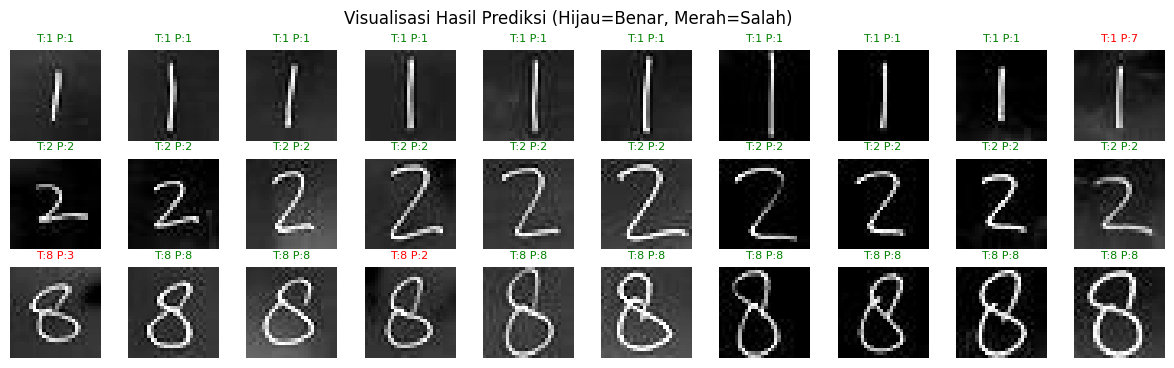

In [78]:
plt.figure(figsize=(15, 4))
for i in range(len(data_citra)):
    plt.subplot(3, 10, i + 1)
    plt.imshow(data_citra[i].squeeze(), cmap='gray')
    color = 'green' if label_citra[i] == hasil[i] else 'red'
    plt.title(f"T:{label_citra[i]} P:{hasil[i]}", color=color, fontsize=8)
    plt.axis('off')
plt.suptitle("Visualisasi Hasil Prediksi (Hijau=Benar, Merah=Salah)")
plt.show()